In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Проектная работа на тему: "Исследование зависимости между бюджетом фильма и полученной прибылью"

#### Загрузка данных

In [2]:
df = pd.read_csv('movies_metadata.csv', dtype='unicode')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
adult                    45466 non-null object
belongs_to_collection    4494 non-null object
budget                   45466 non-null object
genres                   45466 non-null object
homepage                 7782 non-null object
id                       45466 non-null object
imdb_id                  45449 non-null object
original_language        45455 non-null object
original_title           45466 non-null object
overview                 44512 non-null object
popularity               45461 non-null object
poster_path              45080 non-null object
production_companies     45463 non-null object
production_countries     45463 non-null object
release_date             45379 non-null object
revenue                  45460 non-null object
runtime                  45203 non-null object
spoken_languages         45460 non-null object
status                   45379 non-null object


#### Подготовка DataFrame (форматирование и чистка)

##### Удаление лишних столбцов с данными

In [3]:
columns_ = list(df.columns.values)
ex_columns = ['budget', 'revenue', 'title', 'release_date']
dr_columns_ = [i for i in columns_ if not(i in ex_columns)]
df = df.drop(dr_columns_, axis=1)
df.head()

,budget,release_date,revenue,title
0,30000000,1995-10-30,373554033,Toy Story
1,65000000,1995-12-15,262797249,Jumanji
2,0,1995-12-22,0,Grumpier Old Men
3,16000000,1995-12-22,81452156,Waiting to Exhale
4,0,1995-02-10,76578911,Father of the Bride Part II


##### Удаление строк содержащих некорректные значения

In [4]:
df.loc[df['budget'].str.len() > 15, 'budget'] = 0
df['budget'] = df['budget'].astype(float)
df['revenue'] = df['revenue'].astype(float)
df.loc[df['budget'] < 10000, 'budget'] = 0
df.loc[df['revenue'] < 10000, 'revenue'] = 0
df.head()

,budget,release_date,revenue,title
0,30000000.0,1995-10-30,373554033.0,Toy Story
1,65000000.0,1995-12-15,262797249.0,Jumanji
2,0.0,1995-12-22,0.0,Grumpier Old Men
3,16000000.0,1995-12-22,81452156.0,Waiting to Exhale
4,0.0,1995-02-10,76578911.0,Father of the Bride Part II


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 4 columns):
budget          45466 non-null float64
release_date    45379 non-null object
revenue         45460 non-null float64
title           45460 non-null object
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


In [6]:
df['title'].replace('', np.nan, inplace=True)
df['revenue'].replace(0, np.nan, inplace=True)
df['budget'].replace(0, np.nan, inplace=True)
df['release_date'].replace('', np.nan, inplace=True)
df.dropna(subset=['title', 'revenue', 'budget', 'release_date'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5280 entries, 0 to 45422
Data columns (total 4 columns):
budget          5280 non-null float64
release_date    5280 non-null object
revenue         5280 non-null float64
title           5280 non-null object
dtypes: float64(2), object(2)
memory usage: 206.2+ KB


##### Удаление дубликатов

In [7]:
sum(df.duplicated())

5

In [8]:
df.drop_duplicates(inplace = True)

##### Форматирование даты выхода

In [9]:
df['release_date'] = df['release_date'].str.split('-').str[0]
df['release_date'] = df['release_date'].astype(int)
df['release_date'].head()

0    1995
1    1995
3    1995
5    1995
8    1995
Name: release_date, dtype: int32

In [10]:
df['release_date'].values.min(), df['release_date'].values.max()

(1915, 2017)

##### Графики роста средних прибыли и бюджета фильмов по годам

In [11]:
year_bud = (df[['release_date', 'budget']].groupby('release_date').mean())
year_rev = (df[['release_date', 'revenue']].groupby('release_date').mean())

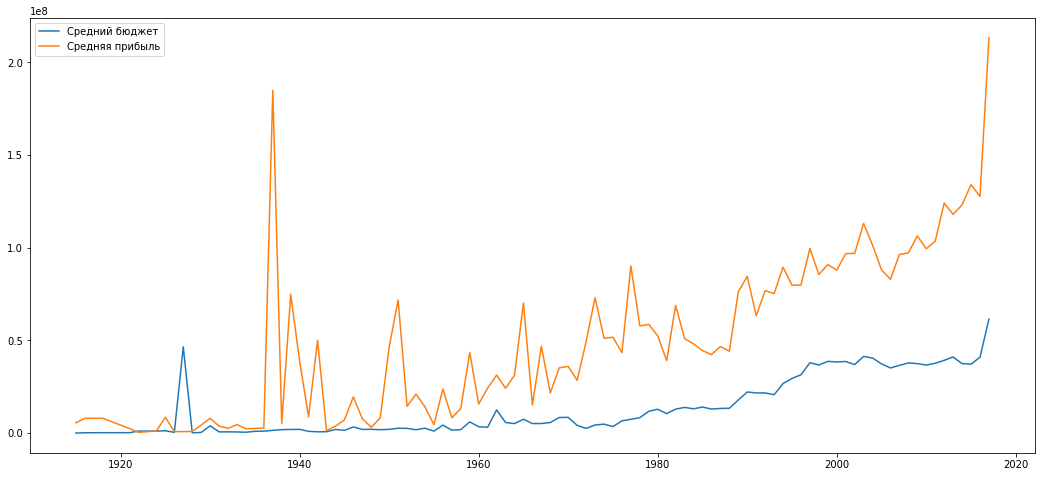

In [12]:
plt.figure(figsize=(18, 8))

plt.plot(year_bud)
plt.plot(year_rev)
plt.legend(('Средний бюджет', 'Средняя прибыль'))
plt.show()

##### Удаление данных фильмов снятых до 1960 года

In [13]:
df = df.loc[df['release_date'].between(1960, 2017), :]

In [14]:
df.head()

,budget,release_date,revenue,title
0,30000000.0,1995,373554033.0,Toy Story
1,65000000.0,1995,262797249.0,Jumanji
3,16000000.0,1995,81452156.0,Waiting to Exhale
5,60000000.0,1995,187436818.0,Heat
8,35000000.0,1995,64350171.0,Sudden Death


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5103 entries, 0 to 45422
Data columns (total 4 columns):
budget          5103 non-null float64
release_date    5103 non-null int32
revenue         5103 non-null float64
title           5103 non-null object
dtypes: float64(2), int32(1), object(1)
memory usage: 179.4+ KB


После очистки датафрейм состоит из 5103 строк и будет использоваться для поиска корреляции между бюджетом и доходами.

### Поиск корреляции между бюджетом и доходами

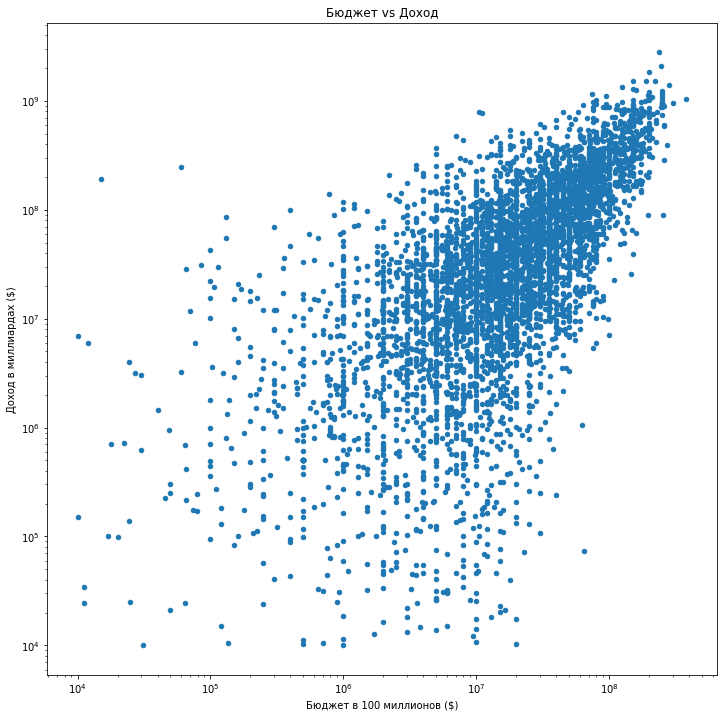

In [16]:
df.plot(x='budget', y='revenue', kind='scatter', figsize=(12, 12))
plt.yscale('log')
plt.xscale('log')
plt.title('Бюджет vs Доход')
plt.xlabel('Бюджет в 100 миллионов ($)')
plt.ylabel('Доход в миллиардах ($)')
plt.show()

#### Расчет коэффициента корреляции Пирсона

In [17]:
corr_coef = np.corrcoef(df['budget'], df['revenue'])[0][1]
corr_coef

0.7289153256910547

Из диаграммы и значения 0,73 для коэффициента Пирсона можно сделать вывод, что существует положительная связь между бюджетами фильмов и их доходами. Однако коэффициент корреляции недостаточно высок. Из диаграммы видно, что есть фильмы с высоким бюджетом, но низким доходом, а есть фильмы с низким бюджетом и высоким доходом. Выбросы больше с высокобюджетными фильмами, которые получают низкие/умеренные доходы.

In [18]:
df['rev_bud'] = df['revenue'] / df['budget'] * 100

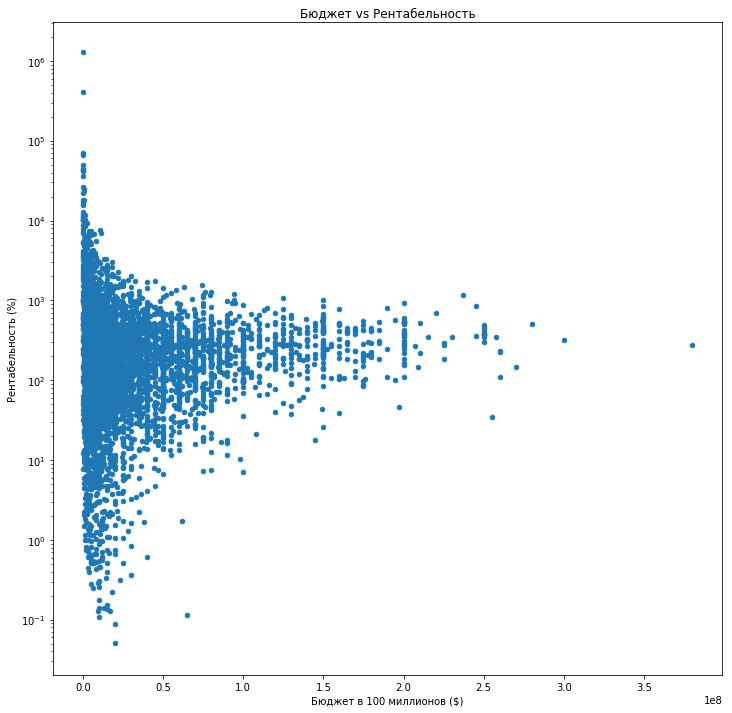

In [19]:
df.plot(x='budget', y='rev_bud', kind='scatter', figsize=(12, 12))

plt.yscale('log')
plt.title('Бюджет vs Рентабельность')
plt.xlabel('Бюджет в 100 миллионов ($)')
plt.ylabel('Рентабельность (%)')

plt.show()

Предыдущий график строился на полной прибыли, полученной от проката фильма, что не дает четкого представления о его денежном успехе. Более справедилый результат можно получить оценивая не полный доход фильма, а его рентабельность. И из этого графика уже видно, что рентабельность инвестиций высока для низкобюджетных фильмов и уменьшается по мере увеличения бюджета фильма.

In [20]:
us_inf = pd.read_csv('inflation.csv', dtype='unicode')
us_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 2 columns):
Year     106 non-null object
Total    106 non-null object
dtypes: object(2)
memory usage: 1.7+ KB


In [21]:
us_inf['Year'] = us_inf['Year'].astype(int)
us_inf['Total'] = us_inf['Total'].astype(float)
us_inf = us_inf.loc[us_inf['Year'].between(1960, 2017), :]
us_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 47 to 104
Data columns (total 2 columns):
Year     58 non-null int32
Total    58 non-null float64
dtypes: float64(1), int32(1)
memory usage: 1.1 KB


In [22]:
df = df.rename(columns={'release_date': 'Year'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5103 entries, 0 to 45422
Data columns (total 5 columns):
budget     5103 non-null float64
Year       5103 non-null int32
revenue    5103 non-null float64
title      5103 non-null object
rev_bud    5103 non-null float64
dtypes: float64(3), int32(1), object(1)
memory usage: 219.3+ KB


In [23]:
df = pd.merge(df, us_inf, how='left', on='Year')
df.head()

,budget,Year,revenue,title,rev_bud,Total
0,30000000.0,1995,373554033.0,Toy Story,1245.180110,2.54
1,65000000.0,1995,262797249.0,Jumanji,404.303460,2.54
2,16000000.0,1995,81452156.0,Waiting to Exhale,509.075975,2.54
3,60000000.0,1995,187436818.0,Heat,312.394697,2.54
4,35000000.0,1995,64350171.0,Sudden Death,183.857631,2.54


In [32]:
df['ia_inflation'] = (df.Total / 100)
df['ia_budget'] = np.dot(df['budget'], df['ia_inflation'])
df['ia_revenue'] = np.dot(df['revenue'], df['ia_inflation'])
df.head()

,budget,Year,revenue,title,rev_bud,Total,ia_budget,ia_revenue,ia_inflation
0,30000000.0,1995,373554033.0,Toy Story,1245.180110,2.54,3.912637e+09,1.169201e+10,0.0254
1,65000000.0,1995,262797249.0,Jumanji,404.303460,2.54,3.912637e+09,1.169201e+10,0.0254
2,16000000.0,1995,81452156.0,Waiting to Exhale,509.075975,2.54,3.912637e+09,1.169201e+10,0.0254
3,60000000.0,1995,187436818.0,Heat,312.394697,2.54,3.912637e+09,1.169201e+10,0.0254
4,35000000.0,1995,64350171.0,Sudden Death,183.857631,2.54,3.912637e+09,1.169201e+10,0.0254


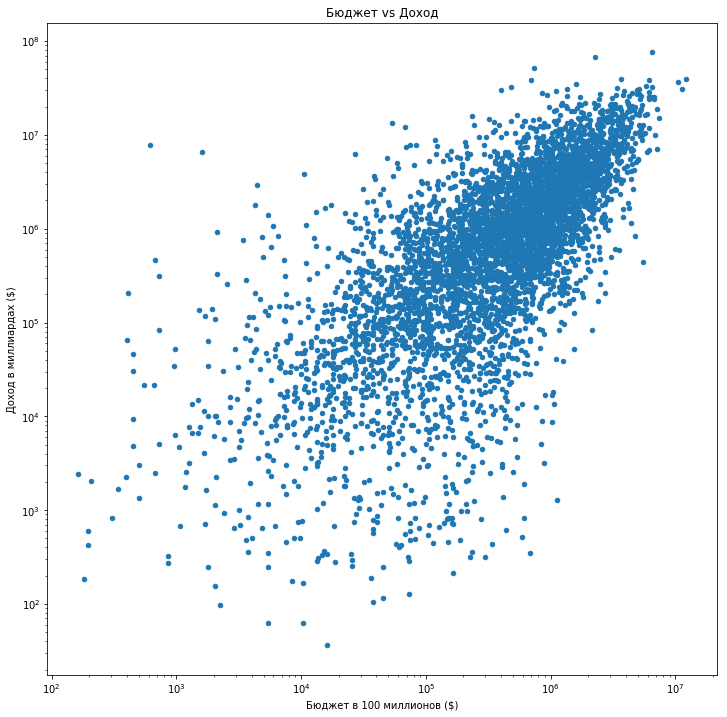

In [30]:
df.plot(x='ia_budget', y='ia_revenue', kind='scatter', figsize=(12, 12))
plt.yscale('log')
plt.xscale('log')
plt.title('Бюджет vs Доход')
plt.xlabel('Бюджет в 100 миллионов ($)')
plt.ylabel('Доход в миллиардах ($)')
plt.show()

In [31]:
corr_coef = np.corrcoef(df['ia_budget'], df['ia_revenue'])[0][1]
corr_coef

0.6536236946795702